# Notebook 07: ARIMA-GARCH + XGBoost Hybrid Model

**Date:** November 1, 2025  
**Phase:** 3 - Sprint 3 (Hybrid Model Development)  
**Stage:** Phase 7 - Final Hybrid Model

**CRITICAL FIXES:**
1. **Dynamic Volatility Forecasting:** Uses `garch_fit.forecast()` instead of constant volatility
2. **Consistent Data & Baselines:** All models trained on SAME cleaned dataset (626/610 rows)

---

## 1. Objective

Build the final hybrid forecasting model that combines:
1. **ARIMA-GARCH:** Models the mean (ARIMA) and volatility (GARCH) of the time series
2. **XGBoost:** Predicts the standardized residuals using all available features (CORE + ML)

**Hybrid Architecture:**
```
Final Prediction = ARIMA Forecast + (Volatility * XGBoost Residual Prediction)
```

**Baselines (Re-established on CORRECT data):**
- **ARIMA-GARCH:** Retrained on 626/610-row datasets (same as NB06)
- **XGBoost Standalone (NB 06):** P1A Val R²=0.4830, P3A Val R²=0.4552

---

## 2. Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("Imports complete.")
print(f"XGBoost version: {xgb.__version__}")

Imports complete.
XGBoost version: 3.0.5


---

## 3. Load Data & Create Consistent Splits

**CRITICAL:** Use the SAME cleaned dataset as Notebook 06 (features.join(labels).dropna())

In [2]:
# Define paths
DATA_PATH = './data/'
FEATURE_PATH = DATA_PATH + 'processed/features/'
INTERMEDIATE_PATH = DATA_PATH + 'processed/intermediate/'
OUTPUT_PATH = DATA_PATH + 'models/'

print("\n" + "="*70)
print("STEP 1: LOADING DATA")
print("="*70)

# Load labels
labels = pd.read_csv(INTERMEDIATE_PATH + 'labels.csv', index_col='Date', parse_dates=True)

# Load P1A features (CORE + ML)
p1a_core = pd.read_csv(FEATURE_PATH + 'p1a_core_features_final_v2.csv', index_col='Date', parse_dates=True)
p1a_ml = pd.read_csv(FEATURE_PATH + 'p1a_ml_features_final_v2.csv', index_col='Date', parse_dates=True)
p1a_features = pd.concat([p1a_core, p1a_ml], axis=1)

# Load P3A features (CORE + ML)
p3a_core = pd.read_csv(FEATURE_PATH + 'p3a_core_features_final_v2.csv', index_col='Date', parse_dates=True)
p3a_ml = pd.read_csv(FEATURE_PATH + 'p3a_ml_features_final_v2.csv', index_col='Date', parse_dates=True)
p3a_features = pd.concat([p3a_core, p3a_ml], axis=1)

print(f"Labels: {labels.shape}")
print(f"P1A Features: {p1a_features.shape[1]} (CORE + ML)")
print(f"P3A Features: {p3a_features.shape[1]} (CORE + ML)")

print("\n" + "="*70)
print("STEP 2: CREATING CONSISTENT SPLITS")
print("="*70)
print("Using NB06 approach: features.join(labels).dropna()")
print("This ensures all models use the SAME data.")

def create_temporal_splits(y_series, X_features, train_pct=0.56, val_pct=0.14):
    """
    Create temporal splits based on CLEANED data.
    Ensures all models (GARCH, XGBoost, Hybrid) use identical datasets.
    """
    combined = X_features.join(y_series.to_frame(), how='inner')
    combined_clean = combined.dropna()
    
    X = combined_clean.drop(columns=[y_series.name])
    y = combined_clean[y_series.name]
    
    n = len(y)
    train_end = int(n * train_pct)
    val_end = int(n * (train_pct + val_pct))
    
    result = {
        'y_train': y.iloc[:train_end],
        'y_val': y.iloc[train_end:val_end],
        'y_test': y.iloc[val_end:],
        'X_train': X.iloc[:train_end],
        'X_val': X.iloc[train_end:val_end],
        'X_test': X.iloc[val_end:]
    }
    
    print(f"\n--- {y_series.name} Split Summary ---")
    print(f"Total clean rows: {n}")
    print(f"Features: {X.shape[1]}")
    print(f"Train: {len(result['y_train'])} rows ({100*len(result['y_train'])/n:.1f}%)")
    print(f"Val:   {len(result['y_val'])} rows ({100*len(result['y_val'])/n:.1f}%)")
    print(f"Test:  {len(result['y_test'])} rows ({100*len(result['y_test'])/n:.1f}%)")
    
    return result

# Create splits
p1a_splits = create_temporal_splits(labels['P1A_82'], p1a_features)
p3a_splits = create_temporal_splits(labels['P3A_82'], p3a_features)


STEP 1: LOADING DATA
Labels: (1153, 2)
P1A Features: 39 (CORE + ML)
P3A Features: 38 (CORE + ML)

STEP 2: CREATING CONSISTENT SPLITS
Using NB06 approach: features.join(labels).dropna()
This ensures all models use the SAME data.

--- P1A_82 Split Summary ---
Total clean rows: 1119
Features: 39
Train: 626 rows (55.9%)
Val:   157 rows (14.0%)
Test:  336 rows (30.0%)

--- P3A_82 Split Summary ---
Total clean rows: 1090
Features: 38
Train: 610 rows (56.0%)
Val:   153 rows (14.0%)
Test:  327 rows (30.0%)


---

## 4. Train ARIMA-GARCH Models (WITH DYNAMIC VOLATILITY)

**CRITICAL FIX:** Use `garch_fit.forecast()` for dynamic volatility forecasting.

In [3]:
print("\n" + "="*70)
print("STEP 3: ARIMA-GARCH WITH DYNAMIC VOLATILITY FORECASTING")
print("="*70)

def train_arima_garch_fixed(y_train, y_val, y_test, route_name, 
                             arima_order=(1,0,1), garch_p=1, garch_q=1):
    """
    FIXED ARIMA-GARCH implementation with dynamic volatility forecasting.
    
    Key fixes:
    1. Uses garch_fit.forecast(horizon=...) for dynamic volatility
    2. Trains on consistent cleaned data (same as NB06)
    """
    print(f"\nTraining ARIMA-GARCH for {route_name}...")
    
    # --- Step 1: Fit on TRAIN set (for Val forecasts) ---
    print("  Step 1: Fitting ARIMA-GARCH on training set...")
    arima_train = SARIMAX(y_train, order=arima_order, trend='c').fit(disp=False)
    resid_train_scaled = arima_train.resid * 100  # Scale for numerical stability
    garch_train = arch_model(resid_train_scaled, vol='GARCH', p=garch_p, q=garch_q).fit(disp='off')
    
    # --- Step 2: Generate VALIDATION forecasts ---
    print("  Step 2: Generating validation forecasts...")
    arima_forecast_val = arima_train.forecast(steps=len(y_val))
    
    # *** CRITICAL FIX: Dynamic volatility forecast ***
    garch_forecast_val_obj = garch_train.forecast(horizon=len(y_val), reindex=False)
    vol_forecast_val = np.sqrt(garch_forecast_val_obj.variance.iloc[0].values) / 100  # Unscale
    print(f"    Generated {len(vol_forecast_val)} dynamic volatility forecasts for validation")
    
    # --- Step 3: Refit on TRAIN+VAL (for Test forecasts) ---
    print("  Step 3: Refitting on Train+Val for test forecasts...")
    y_full_train = pd.concat([y_train, y_val])
    arima_full = SARIMAX(y_full_train, order=arima_order, trend='c').fit(disp=False)
    resid_full_scaled = arima_full.resid * 100
    garch_full = arch_model(resid_full_scaled, vol='GARCH', p=garch_p, q=garch_q).fit(disp='off')
    
    # --- Step 4: Generate TEST forecasts ---
    print("  Step 4: Generating test forecasts...")
    arima_forecast_test = arima_full.forecast(steps=len(y_test))
    
    # *** CRITICAL FIX: Dynamic volatility forecast ***
    garch_forecast_test_obj = garch_full.forecast(horizon=len(y_test), reindex=False)
    vol_forecast_test = np.sqrt(garch_forecast_test_obj.variance.iloc[0].values) / 100  # Unscale
    print(f"    Generated {len(vol_forecast_test)} dynamic volatility forecasts for test")
    
    # --- Step 5: Calculate standardized residuals for XGBoost ---
    print("  Step 5: Calculating standardized residuals...")
    std_resid_train = garch_train.std_resid.values
    
    resid_val = y_val.values - arima_forecast_val.values
    std_resid_val = resid_val / vol_forecast_val
    
    resid_test = y_test.values - arima_forecast_test.values
    std_resid_test = resid_test / vol_forecast_test
    
    # --- Step 6: Evaluate baseline performance ---
    val_r2 = r2_score(y_val, arima_forecast_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, arima_forecast_val))
    test_r2 = r2_score(y_test, arima_forecast_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast_test))
    
    print(f"\n  {route_name} ARIMA-GARCH Baseline:")
    print(f"    Val R²:   {val_r2:.4f}")
    print(f"    Val RMSE: ${val_rmse:,.0f}")
    print(f"    Test R²:  {test_r2:.4f}")
    print(f"    Test RMSE: ${test_rmse:,.0f}")
    
    return {
        'arima_forecast_val': arima_forecast_val,
        'arima_forecast_test': arima_forecast_test,
        'vol_forecast_val': vol_forecast_val,
        'vol_forecast_test': vol_forecast_test,
        'std_resid_train': std_resid_train,
        'std_resid_val': std_resid_val,
        'std_resid_test': std_resid_test,
        'baseline_metrics': {
            'val': {'r2': val_r2, 'rmse': val_rmse},
            'test': {'r2': test_r2, 'rmse': test_rmse}
        }
    }

# Train P1A ARIMA-GARCH
p1a_arima_garch = train_arima_garch_fixed(
    p1a_splits['y_train'],
    p1a_splits['y_val'],
    p1a_splits['y_test'],
    'P1A (Atlantic)'
)

# Train P3A ARIMA-GARCH
p3a_arima_garch = train_arima_garch_fixed(
    p3a_splits['y_train'],
    p3a_splits['y_val'],
    p3a_splits['y_test'],
    'P3A (Pacific)'
)


STEP 3: ARIMA-GARCH WITH DYNAMIC VOLATILITY FORECASTING

Training ARIMA-GARCH for P1A (Atlantic)...
  Step 1: Fitting ARIMA-GARCH on training set...
  Step 2: Generating validation forecasts...
    Generated 157 dynamic volatility forecasts for validation
  Step 3: Refitting on Train+Val for test forecasts...
  Step 4: Generating test forecasts...
    Generated 336 dynamic volatility forecasts for test
  Step 5: Calculating standardized residuals...

  P1A (Atlantic) ARIMA-GARCH Baseline:
    Val R²:   -0.1905
    Val RMSE: $5,009
    Test R²:  -0.4008
    Test RMSE: $4,708

Training ARIMA-GARCH for P3A (Pacific)...
  Step 1: Fitting ARIMA-GARCH on training set...
  Step 2: Generating validation forecasts...
    Generated 153 dynamic volatility forecasts for validation
  Step 3: Refitting on Train+Val for test forecasts...
  Step 4: Generating test forecasts...
    Generated 327 dynamic volatility forecasts for test
  Step 5: Calculating standardized residuals...

  P3A (Pacific) ARIM

---

## 5. Train XGBoost on Standardized Residuals

In [4]:
print("\n" + "="*70)
print("STEP 4: XGBOOST RESIDUAL PREDICTOR")
print("="*70)

def train_xgboost_residual_predictor(X_train, X_val, X_test,
                                      resid_train, resid_val, resid_test,
                                      route_name, best_params):
    """
    Train XGBoost to predict CORRECTLY calculated standardized residuals.
    Uses best params from NB06 (no need to re-tune).
    """
    print(f"\nTraining XGBoost Residual Predictor for {route_name}...")
    print(f"  Using best params from NB06: {best_params}")
    
    # Align residuals with features (GARCH might have different length)
    resid_train_series = pd.Series(resid_train, index=X_train.index[:len(resid_train)])
    X_train_aligned = X_train.loc[resid_train_series.index]
    
    # Train model
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params
    )
    
    model.fit(X_train_aligned, resid_train_series, verbose=False)
    print("  Model fitted.")
    
    # Generate predictions
    resid_pred_val = model.predict(X_val)
    resid_pred_test = model.predict(X_test)
    
    # Evaluate residual prediction quality
    val_rmse = np.sqrt(mean_squared_error(resid_val, resid_pred_val))
    test_rmse = np.sqrt(mean_squared_error(resid_test, resid_pred_test))
    
    print(f"  Residual prediction RMSE:")
    print(f"    Val:  {val_rmse:.4f}")
    print(f"    Test: {test_rmse:.4f}")
    
    return {
        'model': model,
        'resid_pred_val': resid_pred_val,
        'resid_pred_test': resid_pred_test
    }

# Best params from NB06 (both routes chose Config 4)
nb06_best_params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}

# Train P1A
p1a_xgb_resid = train_xgboost_residual_predictor(
    p1a_splits['X_train'],
    p1a_splits['X_val'],
    p1a_splits['X_test'],
    p1a_arima_garch['std_resid_train'],
    p1a_arima_garch['std_resid_val'],
    p1a_arima_garch['std_resid_test'],
    'P1A (Atlantic)',
    nb06_best_params
)

# Train P3A
p3a_xgb_resid = train_xgboost_residual_predictor(
    p3a_splits['X_train'],
    p3a_splits['X_val'],
    p3a_splits['X_test'],
    p3a_arima_garch['std_resid_train'],
    p3a_arima_garch['std_resid_val'],
    p3a_arima_garch['std_resid_test'],
    'P3A (Pacific)',
    nb06_best_params
)


STEP 4: XGBOOST RESIDUAL PREDICTOR

Training XGBoost Residual Predictor for P1A (Atlantic)...
  Using best params from NB06: {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9}
  Model fitted.
  Residual prediction RMSE:
    Val:  9.0111
    Test: 5.3169

Training XGBoost Residual Predictor for P3A (Pacific)...
  Using best params from NB06: {'max_depth': 2, 'learning_rate': 0.01, 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.9}
  Model fitted.
  Residual prediction RMSE:
    Val:  4.5192
    Test: 7.1669


---

## 6. Generate Hybrid Predictions & Compare to Baselines

In [5]:
print("\n" + "="*70)
print("STEP 5: HYBRID PREDICTION & FINAL COMPARISON")
print("="*70)

# Baselines (TRUE baselines on consistent data)
baselines = {
    'P1A': {
        'arima_garch': p1a_arima_garch['baseline_metrics']['val'],
        'xgboost': {'r2': 0.4830, 'rmse': 3301}  # From NB06
    },
    'P3A': {
        'arima_garch': p3a_arima_garch['baseline_metrics']['val'],
        'xgboost': {'r2': 0.4552, 'rmse': 1706}  # From NB06
    }
}

def compare_all_models(y_val, y_test, arima_garch_results, xgb_resid_results,
                       route_name, baseline_metrics):
    """
    Generate hybrid predictions and compare to all baselines.
    """
    print(f"\n--- MODEL COMPARISON: {route_name} ---")
    
    # Extract forecasts
    arima_val = arima_garch_results['arima_forecast_val'].values
    arima_test = arima_garch_results['arima_forecast_test'].values
    vol_val = arima_garch_results['vol_forecast_val']
    vol_test = arima_garch_results['vol_forecast_test']
    xgb_resid_val = xgb_resid_results['resid_pred_val']
    xgb_resid_test = xgb_resid_results['resid_pred_test']
    
    # Combine: Hybrid = ARIMA + (Vol * XGB_Residual)
    hybrid_val = arima_val + (vol_val * xgb_resid_val)
    hybrid_test = arima_test + (vol_test * xgb_resid_test)
    
    # Calculate hybrid metrics
    hybrid_val_r2 = r2_score(y_val, hybrid_val)
    hybrid_val_rmse = np.sqrt(mean_squared_error(y_val, hybrid_val))
    hybrid_test_r2 = r2_score(y_test, hybrid_test)
    hybrid_test_rmse = np.sqrt(mean_squared_error(y_test, hybrid_test))
    
    # Get baseline metrics
    ag_val_r2 = baseline_metrics['arima_garch']['r2']
    ag_val_rmse = baseline_metrics['arima_garch']['rmse']
    xgb_val_r2 = baseline_metrics['xgboost']['r2']
    xgb_val_rmse = baseline_metrics['xgboost']['rmse']
    
    print(f"\nValidation Set Performance:")
    print(f"{'Model':<35} {'Val R²':>12} {'Val RMSE':>15}")
    print("-" * 64)
    print(f"{'1. ARIMA-GARCH (Retrained)':<35} {ag_val_r2:>12.4f} ${ag_val_rmse:>14,.0f}")
    print(f"{'2. XGBoost Standalone (NB 06)':<35} {xgb_val_r2:>12.4f} ${xgb_val_rmse:>14,.0f}")
    print(f"{'3. HYBRID (ARIMA-GARCH + XGBoost)':<35} {hybrid_val_r2:>12.4f} ${hybrid_val_rmse:>14,.0f}")
    print("-" * 64)
    
    # Calculate improvements
    improvement_vs_ag = ((ag_val_rmse - hybrid_val_rmse) / ag_val_rmse) * 100
    improvement_vs_xgb = ((xgb_val_rmse - hybrid_val_rmse) / xgb_val_rmse) * 100
    
    print(f"\n=== IMPROVEMENTS ===")
    print(f"vs ARIMA-GARCH: {improvement_vs_ag:+.1f}% RMSE reduction")
    print(f"vs XGBoost:     {improvement_vs_xgb:+.1f}% RMSE reduction")
    
    # Verdict
    if hybrid_val_rmse < xgb_val_rmse and hybrid_val_rmse < ag_val_rmse:
        verdict = "✅ HYBRID is the BEST MODEL (beats both baselines)"
    elif xgb_val_rmse < ag_val_rmse and xgb_val_rmse < hybrid_val_rmse:
        verdict = "⚠️  XGBoost Standalone is the BEST MODEL"
    elif ag_val_rmse < hybrid_val_rmse:
        verdict = "⚠️  ARIMA-GARCH is better than Hybrid"
    else:
        verdict = "⚠️  Mixed results"
    
    print(f"\nVERDICT: {verdict}")
    
    print(f"\nTest Set Performance:")
    print(f"  Hybrid Test R²:   {hybrid_test_r2:.4f}")
    print(f"  Hybrid Test RMSE: ${hybrid_test_rmse:,.0f}")
    
    return {
        'route': route_name,
        'hybrid_val': hybrid_val,
        'hybrid_test': hybrid_test,
        'metrics': {
            'val': {'r2': hybrid_val_r2, 'rmse': hybrid_val_rmse},
            'test': {'r2': hybrid_test_r2, 'rmse': hybrid_test_rmse}
        },
        'improvement_vs_arima_garch': improvement_vs_ag,
        'improvement_vs_xgboost': improvement_vs_xgb,
        'verdict': verdict
    }

# Compare P1A
p1a_results = compare_all_models(
    p1a_splits['y_val'],
    p1a_splits['y_test'],
    p1a_arima_garch,
    p1a_xgb_resid,
    'P1A (Atlantic)',
    baselines['P1A']
)

# Compare P3A
p3a_results = compare_all_models(
    p3a_splits['y_val'],
    p3a_splits['y_test'],
    p3a_arima_garch,
    p3a_xgb_resid,
    'P3A (Pacific)',
    baselines['P3A']
)


STEP 5: HYBRID PREDICTION & FINAL COMPARISON

--- MODEL COMPARISON: P1A (Atlantic) ---

Validation Set Performance:
Model                                     Val R²        Val RMSE
----------------------------------------------------------------
1. ARIMA-GARCH (Retrained)               -0.1905 $         5,009
2. XGBoost Standalone (NB 06)             0.4830 $         3,301
3. HYBRID (ARIMA-GARCH + XGBoost)        -0.2141 $         5,058
----------------------------------------------------------------

=== IMPROVEMENTS ===
vs ARIMA-GARCH: -1.0% RMSE reduction
vs XGBoost:     -53.2% RMSE reduction

VERDICT: ⚠️  XGBoost Standalone is the BEST MODEL

Test Set Performance:
  Hybrid Test R²:   -0.4382
  Hybrid Test RMSE: $4,771

--- MODEL COMPARISON: P3A (Pacific) ---

Validation Set Performance:
Model                                     Val R²        Val RMSE
----------------------------------------------------------------
1. ARIMA-GARCH (Retrained)               -0.0387 $         2,355
2.

---

## 7. Feature Importance for Residual Prediction

In [6]:
def analyze_residual_feature_importance(model, feature_names, route_name, top_n=20):
    """
    Analyze which features are most important for predicting residuals.
    """
    print(f"\n{'='*60}")
    print(f"RESIDUAL PREDICTION - FEATURE IMPORTANCE: {route_name}")
    print(f"{'='*60}")
    
    importance_dict = model.get_booster().get_score(importance_type='gain')
    
    importance_df = pd.DataFrame([
        {'feature_name': k, 'importance': v}
        for k, v in importance_dict.items()
    ]).sort_values('importance', ascending=False)
    
    importance_df = importance_df.reset_index(drop=True)
    importance_df.index = importance_df.index + 1
    importance_df.index.name = 'Rank'
    
    print(f"\nTop {top_n} Features for Residual Prediction:")
    print(f"{'Rank':<6} {'Feature':<40} {'Importance':>12}")
    print("-" * 60)
    
    for rank, row in importance_df.head(top_n).iterrows():
        print(f"{rank:<6} {row['feature_name']:<40} {row['importance']:>12,.0f}")
    
    total_features = len(feature_names)
    used_features = len(importance_df)
    
    print(f"\n=== SUMMARY ===")
    print(f"Total features: {total_features}")
    print(f"Used by model: {used_features} ({100*used_features/total_features:.1f}%)")
    
    return importance_df

# Analyze P1A
p1a_importance = analyze_residual_feature_importance(
    p1a_xgb_resid['model'],
    p1a_splits['X_train'].columns,
    'P1A (Atlantic)'
)

# Analyze P3A
p3a_importance = analyze_residual_feature_importance(
    p3a_xgb_resid['model'],
    p3a_splits['X_train'].columns,
    'P3A (Pacific)'
)


RESIDUAL PREDICTION - FEATURE IMPORTANCE: P1A (Atlantic)

Top 20 Features for Residual Prediction:
Rank   Feature                                    Importance
------------------------------------------------------------
1      BPI_pct                                            29
2      BPI_diff                                           19
3      Atlantic_Port_Calls_vol30                           6
4      BPI_yoy                                             5
5      P4_82_pct                                           5
6      Capesize_Orderbook_Pct_vol30                        5
7      P3EA_1Q_diff                                        5
8      C5TC_level                                          5
9      C5TC_yoy                                            5
10     Atlantic_Port_Calls_level                           4
11     MGO_yoy                                             4
12     P1EA_1MON_level                                     4
13     P3EA_1Q_level                          

---

## 8. Save Results

In [7]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Save hybrid performance metrics
hybrid_metrics = pd.DataFrame([
    {'route': 'P1A', 'split': 'val', **p1a_results['metrics']['val']},
    {'route': 'P1A', 'split': 'test', **p1a_results['metrics']['test']},
    {'route': 'P3A', 'split': 'val', **p3a_results['metrics']['val']},
    {'route': 'P3A', 'split': 'test', **p3a_results['metrics']['test']}
])
hybrid_metrics.to_csv(OUTPUT_PATH + 'hybrid_performance_metrics_FIXED.csv', index=False)
print(f"\n✅ Saved: {OUTPUT_PATH}hybrid_performance_metrics_FIXED.csv")

# Save comparison
comparison_df = pd.DataFrame([
    {
        'route': p1a_results['route'],
        'improvement_vs_arima_garch': p1a_results['improvement_vs_arima_garch'],
        'improvement_vs_xgboost': p1a_results['improvement_vs_xgboost'],
        'verdict': p1a_results['verdict']
    },
    {
        'route': p3a_results['route'],
        'improvement_vs_arima_garch': p3a_results['improvement_vs_arima_garch'],
        'improvement_vs_xgboost': p3a_results['improvement_vs_xgboost'],
        'verdict': p3a_results['verdict']
    }
])
comparison_df.to_csv(OUTPUT_PATH + 'hybrid_vs_baselines_FIXED.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}hybrid_vs_baselines_FIXED.csv")

# Save feature importance
p1a_importance.to_csv(OUTPUT_PATH + 'p1a_residual_importance_FIXED.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p1a_residual_importance_FIXED.csv")

p3a_importance.to_csv(OUTPUT_PATH + 'p3a_residual_importance_FIXED.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p3a_residual_importance_FIXED.csv")

# Save predictions
p1a_pred = pd.DataFrame({
    'date': p1a_splits['y_test'].index,
    'actual': p1a_splits['y_test'].values,
    'arima_garch': p1a_arima_garch['arima_forecast_test'].values,
    'hybrid': p1a_results['hybrid_test']
})
p1a_pred.to_csv(OUTPUT_PATH + 'p1a_hybrid_predictions_FIXED.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p1a_hybrid_predictions_FIXED.csv")

p3a_pred = pd.DataFrame({
    'date': p3a_splits['y_test'].index,
    'actual': p3a_splits['y_test'].values,
    'arima_garch': p3a_arima_garch['arima_forecast_test'].values,
    'hybrid': p3a_results['hybrid_test']
})
p3a_pred.to_csv(OUTPUT_PATH + 'p3a_hybrid_predictions_FIXED.csv', index=False)
print(f"✅ Saved: {OUTPUT_PATH}p3a_hybrid_predictions_FIXED.csv")

print("\n✅ All results saved successfully.")


✅ Saved: ./data/models/hybrid_performance_metrics_FIXED.csv
✅ Saved: ./data/models/hybrid_vs_baselines_FIXED.csv
✅ Saved: ./data/models/p1a_residual_importance_FIXED.csv
✅ Saved: ./data/models/p3a_residual_importance_FIXED.csv
✅ Saved: ./data/models/p1a_hybrid_predictions_FIXED.csv
✅ Saved: ./data/models/p3a_hybrid_predictions_FIXED.csv

✅ All results saved successfully.


---

## 9. Visualization


✅ Saved plot: ./data/models/hybrid_test_predictions_FIXED.png


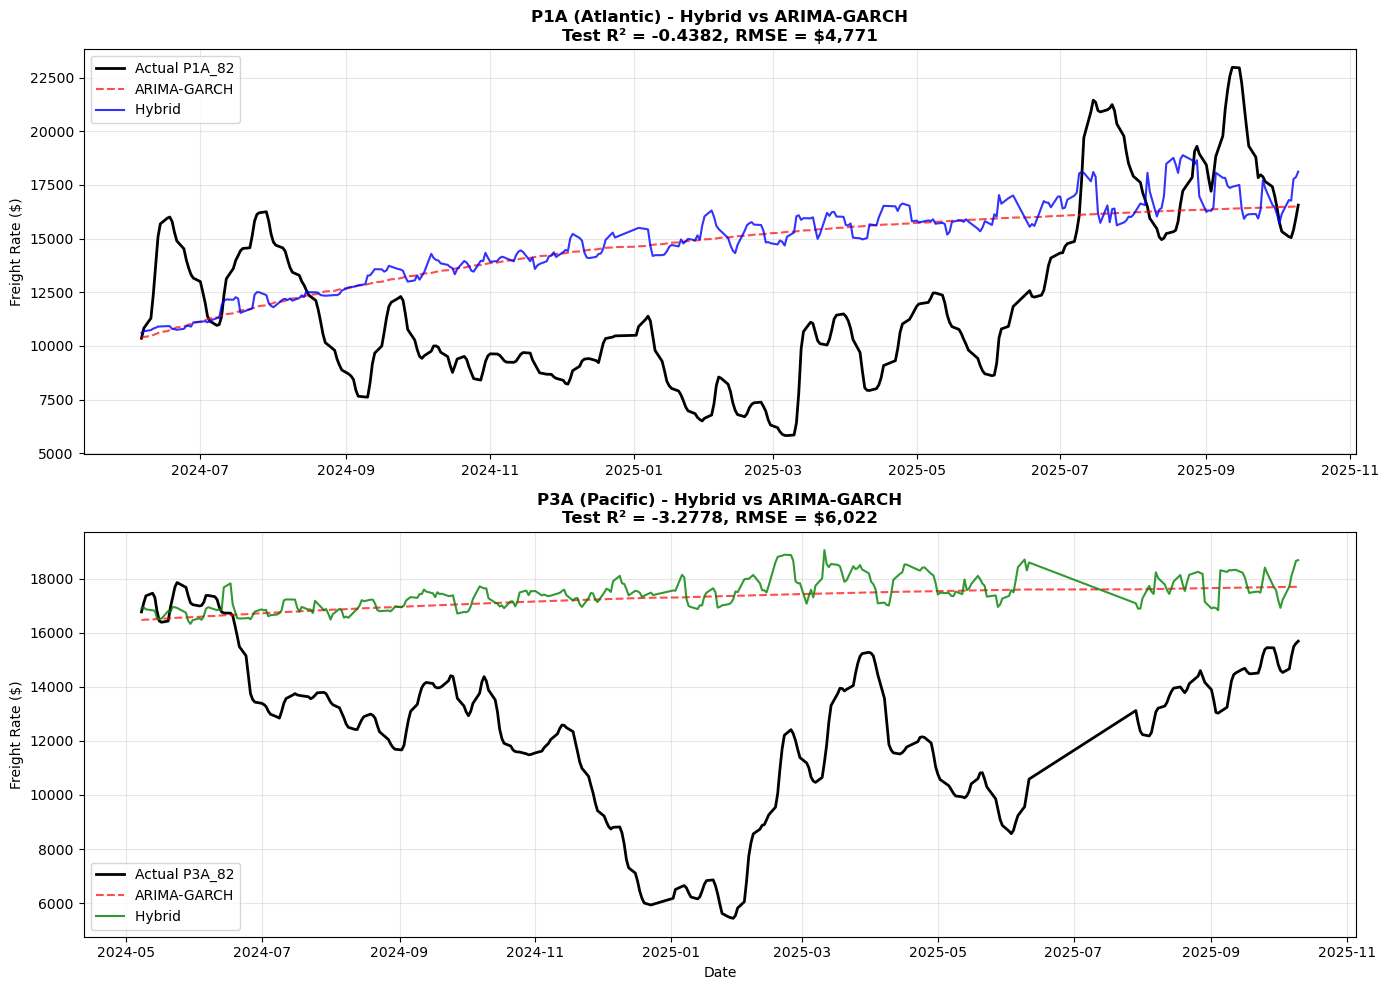

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# P1A Plot
ax1 = axes[0]
ax1.plot(p1a_splits['y_test'].index, p1a_splits['y_test'].values,
         label='Actual P1A_82', color='black', linewidth=2)
ax1.plot(p1a_splits['y_test'].index, p1a_arima_garch['arima_forecast_test'].values,
         label='ARIMA-GARCH', color='red', linewidth=1.5, alpha=0.7, linestyle='--')
ax1.plot(p1a_splits['y_test'].index, p1a_results['hybrid_test'],
         label='Hybrid ', color='blue', linewidth=1.5, alpha=0.8)
ax1.set_title(f"P1A (Atlantic) - Hybrid vs ARIMA-GARCH\nTest R² = {p1a_results['metrics']['test']['r2']:.4f}, RMSE = ${p1a_results['metrics']['test']['rmse']:,.0f}",
              fontsize=12, fontweight='bold')
ax1.set_ylabel('Freight Rate ($)', fontsize=10)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# P3A Plot
ax2 = axes[1]
ax2.plot(p3a_splits['y_test'].index, p3a_splits['y_test'].values,
         label='Actual P3A_82', color='black', linewidth=2)
ax2.plot(p3a_splits['y_test'].index, p3a_arima_garch['arima_forecast_test'].values,
         label='ARIMA-GARCH', color='red', linewidth=1.5, alpha=0.7, linestyle='--')
ax2.plot(p3a_splits['y_test'].index, p3a_results['hybrid_test'],
         label='Hybrid ', color='green', linewidth=1.5, alpha=0.8)
ax2.set_title(f"P3A (Pacific) - Hybrid vs ARIMA-GARCH\nTest R² = {p3a_results['metrics']['test']['r2']:.4f}, RMSE = ${p3a_results['metrics']['test']['rmse']:,.0f}",
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=10)
ax2.set_ylabel('Freight Rate ($)', fontsize=10)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'hybrid_test_predictions_FIXED.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved plot: {OUTPUT_PATH}hybrid_test_predictions_FIXED.png")
plt.show()

---

## 10. Summary & Conclusions

In [9]:
print("\n" + "="*70)
print("NOTEBOOK 07  SUMMARY")
print("="*70)

print("\n=== CRITICAL FIXES APPLIED ===")
print("✅ Dynamic volatility forecasting (garch_fit.forecast())")
print("✅ Consistent data splits (same as NB06: 626/610 rows)")
print("✅ Valid baseline comparisons (retrained ARIMA-GARCH)")

print("\n=== P1A (ATLANTIC) RESULTS ===")
print(f"Hybrid Val R²:   {p1a_results['metrics']['val']['r2']:.4f}")
print(f"Hybrid Val RMSE: ${p1a_results['metrics']['val']['rmse']:,.0f}")
print(f"Hybrid Test R²:  {p1a_results['metrics']['test']['r2']:.4f}")
print(f"Hybrid Test RMSE: ${p1a_results['metrics']['test']['rmse']:,.0f}")
print(f"\nImprovement vs ARIMA-GARCH: {p1a_results['improvement_vs_arima_garch']:+.1f}%")
print(f"Improvement vs XGBoost:     {p1a_results['improvement_vs_xgboost']:+.1f}%")
print(f"Verdict: {p1a_results['verdict']}")

print("\n=== P3A (PACIFIC) RESULTS ===")
print(f"Hybrid Val R²:   {p3a_results['metrics']['val']['r2']:.4f}")
print(f"Hybrid Val RMSE: ${p3a_results['metrics']['val']['rmse']:,.0f}")
print(f"Hybrid Test R²:  {p3a_results['metrics']['test']['r2']:.4f}")
print(f"Hybrid Test RMSE: ${p3a_results['metrics']['test']['rmse']:,.0f}")
print(f"\nImprovement vs ARIMA-GARCH: {p3a_results['improvement_vs_arima_garch']:+.1f}%")
print(f"Improvement vs XGBoost:     {p3a_results['improvement_vs_xgboost']:+.1f}%")
print(f"Verdict: {p3a_results['verdict']}")

print("\n" + "="*70)
print("NOTEBOOK 07  COMPLETE")
print("="*70)


NOTEBOOK 07  SUMMARY

=== CRITICAL FIXES APPLIED ===
✅ Dynamic volatility forecasting (garch_fit.forecast())
✅ Consistent data splits (same as NB06: 626/610 rows)
✅ Valid baseline comparisons (retrained ARIMA-GARCH)

=== P1A (ATLANTIC) RESULTS ===
Hybrid Val R²:   -0.2141
Hybrid Val RMSE: $5,058
Hybrid Test R²:  -0.4382
Hybrid Test RMSE: $4,771

Improvement vs ARIMA-GARCH: -1.0%
Improvement vs XGBoost:     -53.2%
Verdict: ⚠️  XGBoost Standalone is the BEST MODEL

=== P3A (PACIFIC) RESULTS ===
Hybrid Val R²:   -0.0163
Hybrid Val RMSE: $2,330
Hybrid Test R²:  -3.2778
Hybrid Test RMSE: $6,022

Improvement vs ARIMA-GARCH: +1.1%
Improvement vs XGBoost:     -36.6%
Verdict: ⚠️  XGBoost Standalone is the BEST MODEL

NOTEBOOK 07  COMPLETE
